In [1]:
%cd ..

/Users/pavanpreetgandhi/git-repos/interpretable-sla


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from source.fit_predict_score_utils import fit_and_predict, build_score_df, calibrate_score_df, plot_score_df, compute_metrics

In [3]:
nof_non_feature_cols = 5  # speaker_id, subset, part, part_score, overall_score

In [4]:
datasets = {}
dataset_paths = sorted([f for f in os.listdir('datasets') if f.endswith('.parquet')])
for dataset_path in dataset_paths:
    dataset_name = os.path.splitext(dataset_path)[0]
    df = pd.read_parquet(os.path.join('datasets', dataset_path))
    if dataset_name != '7_qwen_2_5_omni_embeddings':
        features = df.columns[nof_non_feature_cols:]
        df[features] = np.exp(df[features])
    datasets[os.path.splitext(dataset_path)[0]] = df

In [5]:
experiments = [
    {
        "name": "Original Question Set",
        "dataset": datasets["1_original_question_set"],
        "features": datasets["1_original_question_set"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", LinearRegression())]),
    },
    {
        "name": "Direct Scoring with Rubric",
        "dataset": datasets["2_direct_scoring_with_rubric"],
        "features": datasets["2_direct_scoring_with_rubric"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", LinearRegression())]),
    },
    {
        "name": "Rubric Based Questions",
        "dataset": datasets["3_rubric_based_questions"],
        "features": datasets["3_rubric_based_questions"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", LinearRegression())]),
    },
    {
        "name": "Rubric Based Questions (Batch Inference)",
        "dataset": datasets["4_rubric_based_questions_batch"],
        "features": datasets["4_rubric_based_questions_batch"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", LinearRegression())]),
    },
    {
        "name": "Revised Question Set",
        "dataset": datasets["5_revised_question_set"],
        "features": datasets["5_revised_question_set"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", LinearRegression())]),
    },
    {
        "name": "Revised Question Set (Batch Inference)",
        "dataset": datasets["6_revised_question_set_batch"],
        "features": datasets["6_revised_question_set_batch"].columns[nof_non_feature_cols:],
        "pipeline": Pipeline([("model", LinearRegression())]),
    },
]

In [6]:
# Add experiment combining all question sets
combined_dataset = None
combined_features = []
for name, dataset in datasets.items():
    if name == '7_qwen_2_5_omni_embeddings':
        continue
    if combined_dataset is None:
        combined_dataset = dataset
    else:
        assert combined_dataset.index.equals(dataset.index), "Datasets have different indices"
        combined_dataset = pd.concat([combined_dataset, dataset.iloc[:, nof_non_feature_cols:]], axis=1)
    combined_features.extend(dataset.columns[nof_non_feature_cols:])

experiments.append({
    "name": "Combined Question Sets",
    "dataset": combined_dataset,
    "features": combined_features,
    "pipeline": Pipeline([("model", LinearRegression())]),
})
print(f"Combined dataset features: {len(combined_features)}")

Combined dataset features: 204


In [7]:
# Random projections
set_to_project = "1_original_question_set"
nof_projected_features = len(combined_features)
print(f"Projecting {set_to_project} to {nof_projected_features} features")
df = datasets[set_to_project]
features = df.columns[nof_non_feature_cols:]
P = np.random.rand(len(features), nof_projected_features) # Random projection matrix
projected_df = df[features].dot(P)  # shape: (n_samples, nof_projected_features)
projected_df.columns = [f'projected_feature_{i}' for i in range(projected_df.shape[1])]
df_projected = df.copy()
df_projected.drop(columns=features, inplace=True)
df_projected = pd.concat([df_projected, projected_df], axis=1)

experiments.append({
    "name": "Random Projections of Original Question Set",
    "dataset": df_projected,
    "features": projected_df.columns.tolist(),
    "pipeline": Pipeline([("model", LinearRegression())]),
})

Projecting 1_original_question_set to 204 features


In [8]:
# Embeddings
experiments.append({
    "name": "Qwen 2.5 Omni Embeddings",
    "dataset": datasets["7_qwen_2_5_omni_embeddings"],
    "features": datasets["7_qwen_2_5_omni_embeddings"].columns[nof_non_feature_cols:],
    "pipeline": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(alphas=np.logspace(2.5, 3.5, 20)))
    ]),
})

In [9]:
# Embeddings + All Question Sets
df_embeddings = datasets["7_qwen_2_5_omni_embeddings"]
features_embeddings = df_embeddings.columns[nof_non_feature_cols:]
df_combined_embeddings = pd.concat([combined_dataset, df_embeddings[features_embeddings]], axis=1)
df_combined_embeddings_features = combined_features + features_embeddings.tolist()
experiments.append({
    "name": "Combined Question Sets + Qwen 2.5 Omni Embeddings",
    "dataset": df_combined_embeddings,
    "features": df_combined_embeddings_features,
    "pipeline": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(alphas=np.logspace(3.0, 3.5, 20)))
    ]),
})

In [10]:
PARTS = ["part_1", "part_3", "part_4", "part_5", "overall"]
SUBSETS = ["train", "dev", "eval"]
score_dfs = {}
calibrated_score_dfs = {}
metrics_all = {f"{subset}_{part}": {} for subset in SUBSETS for part in PARTS}
for experiment in experiments:
    print(f"Running experiment: {experiment['name']}")
    predictions, pipelines = fit_and_predict(
        df=experiment["dataset"],
        features=experiment["features"],
        pipeline=experiment["pipeline"],
    )
    score_df = build_score_df(
        df=experiment["dataset"],
        predictions=predictions,
    )
    calibrated_score_df = calibrate_score_df(
        score_df, 
        calibration_set='dev'
    )
    metrics = compute_metrics(
        score_df=calibrated_score_df,
        n_bootstraps=1000,
        subsets=["train", "dev", "eval"],
    )
    score_dfs[experiment["name"]] = score_df
    calibrated_score_dfs[experiment["name"]] = calibrated_score_df
    for subset in SUBSETS:
        for part in PARTS:
            metrics_all[f"{subset}_{part}"][experiment["name"]] = metrics[subset][part]
    
    for part, pipeline in pipelines.items():
        if hasattr(pipeline.named_steps['model'], 'alpha_'):
            print(f"Best alpha for {experiment['name']} - Part {part}: {pipeline.named_steps['model'].alpha_}")

Running experiment: Original Question Set
Running experiment: Direct Scoring with Rubric
Running experiment: Rubric Based Questions
Running experiment: Rubric Based Questions (Batch Inference)
Running experiment: Revised Question Set
Running experiment: Revised Question Set (Batch Inference)
Running experiment: Combined Question Sets
Running experiment: Random Projections of Original Question Set
Running experiment: Qwen 2.5 Omni Embeddings
Best alpha for Qwen 2.5 Omni Embeddings - Part 1: 1725.2105499420409
Best alpha for Qwen 2.5 Omni Embeddings - Part 3: 1353.8761800225445
Best alpha for Qwen 2.5 Omni Embeddings - Part 4: 1947.483039908757
Best alpha for Qwen 2.5 Omni Embeddings - Part 5: 1199.3539462092344
Running experiment: Combined Question Sets + Qwen 2.5 Omni Embeddings
Best alpha for Combined Question Sets + Qwen 2.5 Omni Embeddings - Part 1: 1947.483039908757
Best alpha for Combined Question Sets + Qwen 2.5 Omni Embeddings - Part 3: 1623.776739188721
Best alpha for Combined 

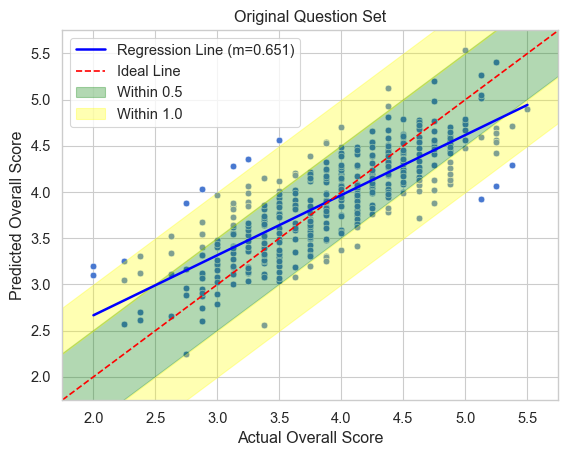

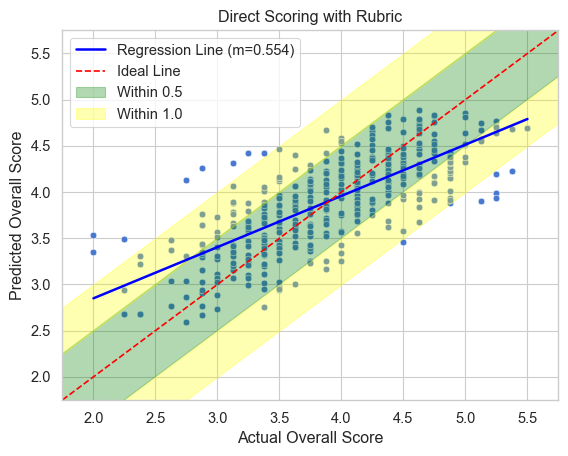

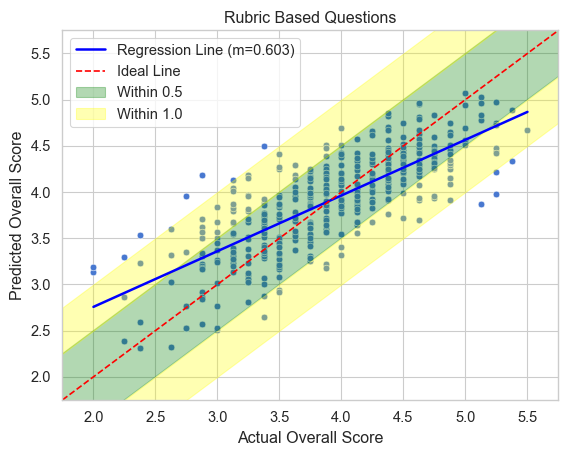

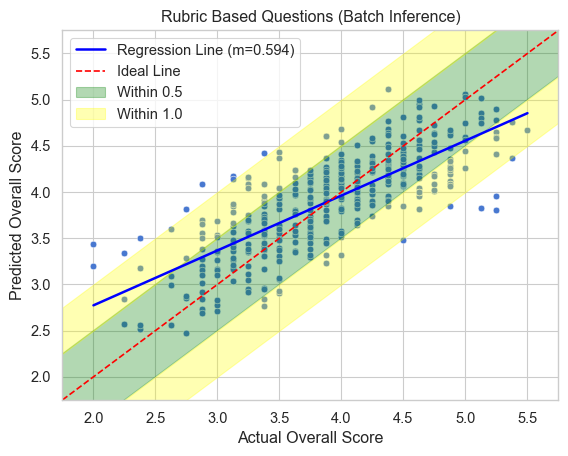

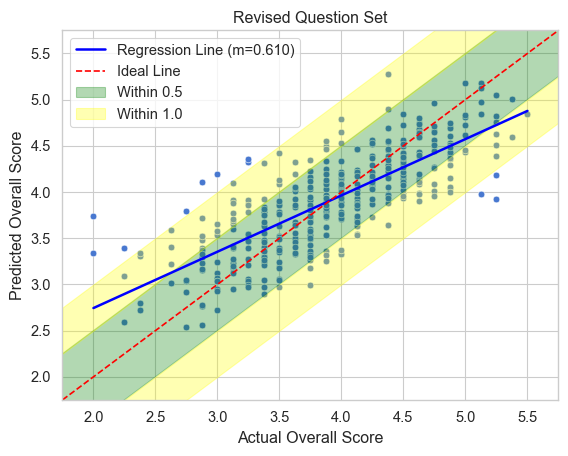

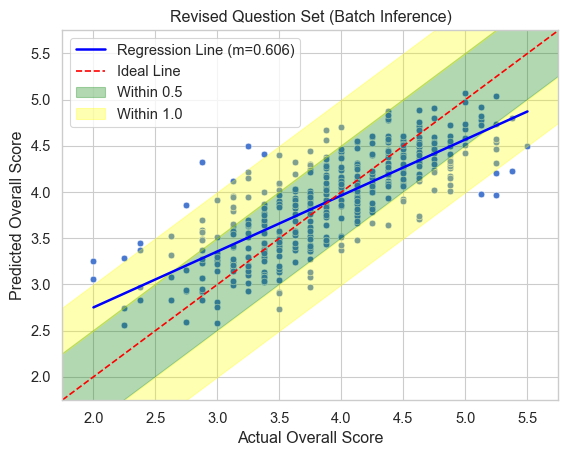

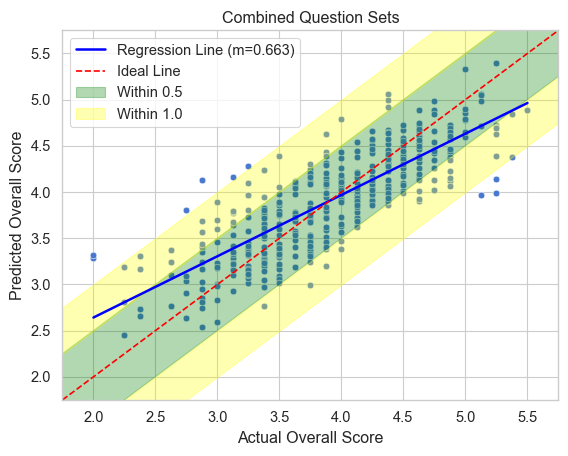

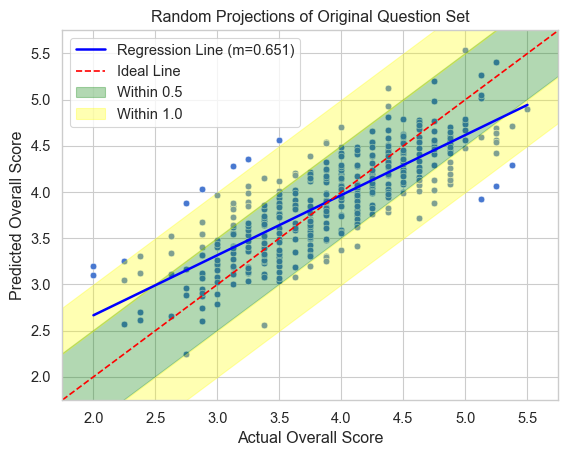

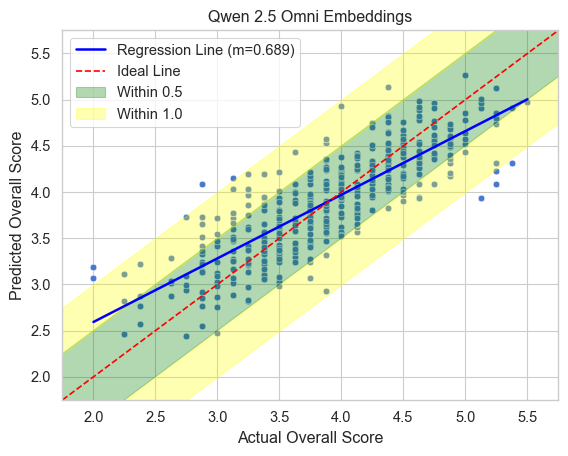

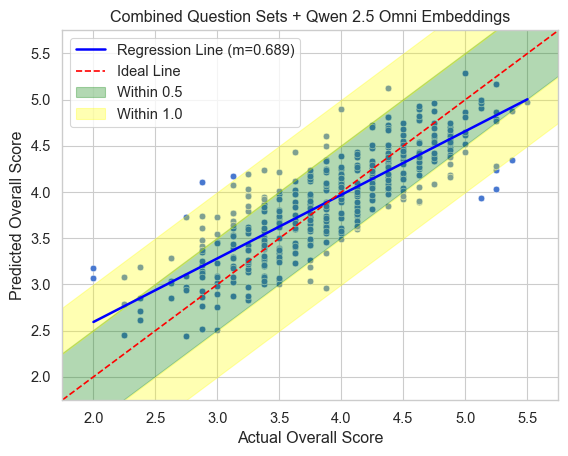

In [11]:
for experiment_name, calibrated_score_df in calibrated_score_dfs.items():
    plot_score_df(calibrated_score_df, experiment_name=experiment_name)

In [12]:
for category, metrics in metrics_all.items():
    print(f"{category}")
    metrics_df = pd.DataFrame(metrics).T.map(lambda x: f"{x[0]:.4f} ± {x[1]:.4f}")
    display(metrics_df)

train_part_1


,rmse,pcc,src,p05,p1
Original Question Set,0.5274 ± 0.0066,0.7054 ± 0.0089,0.6978 ± 0.0098,64.6562 ± 0.8623,93.9720 ± 0.4139
Direct Scoring with Rubric,0.6294 ± 0.0071,0.5403 ± 0.0122,0.5354 ± 0.0128,55.3002 ± 0.8545,88.8799 ± 0.5727
Rubric Based Questions,0.5492 ± 0.0069,0.6697 ± 0.0099,0.6546 ± 0.0109,63.0088 ± 0.8484,93.1054 ± 0.4560
Rubric Based Questions (Batch Inference),0.5726 ± 0.0073,0.6457 ± 0.0108,0.6310 ± 0.0116,61.4764 ± 0.8788,92.2416 ± 0.4945
Revised Question Set,0.5377 ± 0.0068,0.6939 ± 0.0092,0.6892 ± 0.0101,64.2003 ± 0.8445,93.7805 ± 0.4281
Revised Question Set (Batch Inference),0.5439 ± 0.0070,0.6873 ± 0.0097,0.6761 ± 0.0107,62.9601 ± 0.8497,93.7962 ± 0.4414
Combined Question Sets,0.5011 ± 0.0064,0.7389 ± 0.0082,0.7315 ± 0.0091,67.2596 ± 0.8334,95.6115 ± 0.3587
Random Projections of Original Question Set,0.5274 ± 0.0066,0.7054 ± 0.0089,0.6978 ± 0.0098,64.6562 ± 0.8623,93.9720 ± 0.4139
Qwen 2.5 Omni Embeddings,0.4380 ± 0.0057,0.8099 ± 0.0062,0.7993 ± 0.0073,74.6347 ± 0.7939,97.8500 ± 0.2578
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.4377 ± 0.0057,0.8101 ± 0.0062,0.7997 ± 0.0073,74.8205 ± 0.7875,97.8119 ± 0.2621


train_part_3


,rmse,pcc,src,p05,p1
Original Question Set,0.5173 ± 0.0068,0.6756 ± 0.0104,0.6573 ± 0.0111,67.1350 ± 0.8505,94.8450 ± 0.3947
Direct Scoring with Rubric,0.5710 ± 0.0069,0.5860 ± 0.0125,0.5701 ± 0.0132,59.9521 ± 0.9193,92.5707 ± 0.4887
Rubric Based Questions,0.5589 ± 0.0068,0.6039 ± 0.0118,0.5811 ± 0.0130,61.8055 ± 0.8939,93.1885 ± 0.4600
Rubric Based Questions (Batch Inference),0.5622 ± 0.0069,0.6115 ± 0.0120,0.5826 ± 0.0131,61.4423 ± 0.9046,92.9411 ± 0.4792
Revised Question Set,0.5264 ± 0.0066,0.6672 ± 0.0105,0.6488 ± 0.0117,65.5116 ± 0.8761,94.3775 ± 0.4220
Revised Question Set (Batch Inference),0.5480 ± 0.0069,0.6301 ± 0.0114,0.6142 ± 0.0119,61.5117 ± 0.8968,93.2531 ± 0.4704
Combined Question Sets,0.4780 ± 0.0060,0.7361 ± 0.0086,0.7144 ± 0.0099,69.8635 ± 0.8429,96.4968 ± 0.3323
Random Projections of Original Question Set,0.5173 ± 0.0068,0.6756 ± 0.0104,0.6573 ± 0.0111,67.1350 ± 0.8505,94.8450 ± 0.3947
Qwen 2.5 Omni Embeddings,0.4181 ± 0.0054,0.8056 ± 0.0066,0.7910 ± 0.0076,77.6290 ± 0.7339,98.2273 ± 0.2432
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.4183 ± 0.0054,0.8060 ± 0.0065,0.7918 ± 0.0076,77.2069 ± 0.7551,98.2243 ± 0.2431


train_part_4


,rmse,pcc,src,p05,p1
Original Question Set,0.5524 ± 0.0070,0.6860 ± 0.0094,0.6775 ± 0.0103,63.0600 ± 0.8926,93.0777 ± 0.4565
Direct Scoring with Rubric,0.6122 ± 0.0078,0.5894 ± 0.0113,0.5884 ± 0.0120,58.0988 ± 0.9059,88.9862 ± 0.5663
Rubric Based Questions,0.5938 ± 0.0074,0.6228 ± 0.0110,0.6139 ± 0.0119,59.0795 ± 0.8960,90.8602 ± 0.5340
Rubric Based Questions (Batch Inference),0.5889 ± 0.0075,0.6282 ± 0.0108,0.6206 ± 0.0116,59.8140 ± 0.9130,91.3891 ± 0.5125
Revised Question Set,0.5573 ± 0.0068,0.6778 ± 0.0093,0.6675 ± 0.0104,62.2504 ± 0.8871,92.6150 ± 0.4646
Revised Question Set (Batch Inference),0.5939 ± 0.0076,0.6199 ± 0.0105,0.6215 ± 0.0113,59.4414 ± 0.8985,90.9719 ± 0.5442
Combined Question Sets,0.5098 ± 0.0066,0.7445 ± 0.0080,0.7345 ± 0.0092,68.4227 ± 0.8490,94.8677 ± 0.4002
Random Projections of Original Question Set,0.5524 ± 0.0070,0.6860 ± 0.0094,0.6775 ± 0.0103,63.0600 ± 0.8926,93.0777 ± 0.4565
Qwen 2.5 Omni Embeddings,0.4648 ± 0.0058,0.7991 ± 0.0063,0.7895 ± 0.0075,71.8387 ± 0.8206,97.0764 ± 0.3093
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.4612 ± 0.0058,0.8038 ± 0.0062,0.7945 ± 0.0073,72.2365 ± 0.8133,96.9053 ± 0.3169


train_part_5


,rmse,pcc,src,p05,p1
Original Question Set,0.4898 ± 0.0070,0.7292 ± 0.0090,0.7202 ± 0.0099,69.1453 ± 0.8398,95.8487 ± 0.3830
Direct Scoring with Rubric,0.5789 ± 0.0073,0.5882 ± 0.0125,0.5757 ± 0.0131,60.5999 ± 0.8933,92.0375 ± 0.4862
Rubric Based Questions,0.5055 ± 0.0064,0.7063 ± 0.0091,0.6942 ± 0.0100,67.2601 ± 0.8727,95.2546 ± 0.3810
Rubric Based Questions (Batch Inference),0.5309 ± 0.0068,0.6656 ± 0.0101,0.6555 ± 0.0111,65.6838 ± 0.8978,94.3317 ± 0.4161
Revised Question Set,0.5029 ± 0.0063,0.7134 ± 0.0089,0.7067 ± 0.0100,67.1068 ± 0.8432,95.8015 ± 0.3725
Revised Question Set (Batch Inference),0.5071 ± 0.0064,0.7077 ± 0.0091,0.6953 ± 0.0102,67.4535 ± 0.8384,95.6766 ± 0.3654
Combined Question Sets,0.4585 ± 0.0063,0.7673 ± 0.0078,0.7543 ± 0.0089,72.8722 ± 0.8176,96.8454 ± 0.3236
Random Projections of Original Question Set,0.4898 ± 0.0070,0.7292 ± 0.0090,0.7202 ± 0.0099,69.1453 ± 0.8398,95.8487 ± 0.3830
Qwen 2.5 Omni Embeddings,0.3932 ± 0.0052,0.8367 ± 0.0055,0.8237 ± 0.0066,79.5343 ± 0.7596,99.0198 ± 0.1787
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.3947 ± 0.0053,0.8352 ± 0.0055,0.8219 ± 0.0067,79.4283 ± 0.7665,98.8966 ± 0.1858


train_overall


,rmse,pcc,src,p05,p1
Original Question Set,0.4200 ± 0.0081,0.7640 ± 0.0103,0.7630 ± 0.0116,78.7502 ± 1.0011,97.7460 ± 0.3515
Direct Scoring with Rubric,0.4901 ± 0.0089,0.6660 ± 0.0137,0.6653 ± 0.0145,70.4123 ± 1.0931,95.8042 ± 0.4737
Rubric Based Questions,0.4520 ± 0.0087,0.7195 ± 0.0119,0.7175 ± 0.0130,75.1253 ± 1.0638,97.0038 ± 0.3934
Rubric Based Questions (Batch Inference),0.4617 ± 0.0087,0.7073 ± 0.0124,0.7056 ± 0.0135,74.3932 ± 1.0707,96.1461 ± 0.4421
Revised Question Set,0.4322 ± 0.0081,0.7496 ± 0.0109,0.7477 ± 0.0121,76.8392 ± 1.0014,97.8076 ± 0.3348
Revised Question Set (Batch Inference),0.4435 ± 0.0081,0.7334 ± 0.0111,0.7377 ± 0.0120,76.8037 ± 1.0117,96.9306 ± 0.3958
Combined Question Sets,0.3901 ± 0.0074,0.7994 ± 0.0092,0.7971 ± 0.0104,82.5045 ± 0.8908,98.1440 ± 0.3212
Random Projections of Original Question Set,0.4200 ± 0.0081,0.7640 ± 0.0103,0.7630 ± 0.0116,78.7502 ± 1.0011,97.7460 ± 0.3515
Qwen 2.5 Omni Embeddings,0.3458 ± 0.0066,0.8476 ± 0.0071,0.8458 ± 0.0082,86.5688 ± 0.7929,99.0229 ± 0.2315
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.3444 ± 0.0066,0.8486 ± 0.0070,0.8466 ± 0.0082,86.5246 ± 0.7857,99.0229 ± 0.2315


dev_part_1


,rmse,pcc,src,p05,p1
Original Question Set,0.5337 ± 0.0181,0.7296 ± 0.0207,0.7277 ± 0.0230,65.1434 ± 2.3093,93.3429 ± 1.2340
Direct Scoring with Rubric,0.6366 ± 0.0206,0.5785 ± 0.0297,0.5815 ± 0.0313,54.4779 ± 2.4055,88.5459 ± 1.5337
Rubric Based Questions,0.5428 ± 0.0174,0.7184 ± 0.0213,0.7114 ± 0.0242,61.9947 ± 2.4122,93.1479 ± 1.1918
Rubric Based Questions (Batch Inference),0.5580 ± 0.0183,0.6989 ± 0.0238,0.6804 ± 0.0275,62.2215 ± 2.2659,92.6326 ± 1.2893
Revised Question Set,0.5495 ± 0.0191,0.7099 ± 0.0223,0.7133 ± 0.0236,64.9514 ± 2.3064,92.4361 ± 1.2969
Revised Question Set (Batch Inference),0.5483 ± 0.0181,0.7115 ± 0.0217,0.7110 ± 0.0234,61.2623 ± 2.3560,94.7505 ± 1.0655
Combined Question Sets,0.5182 ± 0.0174,0.7477 ± 0.0193,0.7506 ± 0.0207,64.4815 ± 2.4141,94.9553 ± 1.0415
Random Projections of Original Question Set,0.5337 ± 0.0181,0.7296 ± 0.0207,0.7277 ± 0.0230,65.1434 ± 2.3093,93.3429 ± 1.2340
Qwen 2.5 Omni Embeddings,0.4920 ± 0.0156,0.7761 ± 0.0178,0.7740 ± 0.0187,66.9872 ± 2.2787,96.1235 ± 0.9016
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.4940 ± 0.0159,0.7741 ± 0.0180,0.7711 ± 0.0191,68.1735 ± 2.2579,95.4260 ± 0.9877


dev_part_3


,rmse,pcc,src,p05,p1
Original Question Set,0.5451 ± 0.0237,0.6641 ± 0.0323,0.6623 ± 0.0316,65.4575 ± 2.3107,94.3315 ± 1.1323
Direct Scoring with Rubric,0.5945 ± 0.0237,0.5793 ± 0.0357,0.5865 ± 0.0333,58.5066 ± 2.3059,92.5247 ± 1.2580
Rubric Based Questions,0.5795 ± 0.0233,0.6072 ± 0.0357,0.6041 ± 0.0339,62.0393 ± 2.3643,92.0922 ± 1.2756
Rubric Based Questions (Batch Inference),0.5842 ± 0.0232,0.5986 ± 0.0354,0.6005 ± 0.0331,61.0687 ± 2.3303,92.5224 ± 1.2436
Revised Question Set,0.5661 ± 0.0229,0.6305 ± 0.0317,0.6340 ± 0.0308,64.9438 ± 2.3049,94.0906 ± 1.1588
Revised Question Set (Batch Inference),0.5766 ± 0.0218,0.6124 ± 0.0319,0.6267 ± 0.0319,61.2847 ± 2.2746,93.6564 ± 1.2027
Combined Question Sets,0.5326 ± 0.0225,0.6829 ± 0.0289,0.6925 ± 0.0281,67.7365 ± 2.0807,95.4696 ± 1.0281
Random Projections of Original Question Set,0.5451 ± 0.0237,0.6641 ± 0.0323,0.6623 ± 0.0316,65.4575 ± 2.3107,94.3315 ± 1.1323
Qwen 2.5 Omni Embeddings,0.5115 ± 0.0207,0.7129 ± 0.0259,0.7254 ± 0.0250,68.3941 ± 2.1361,95.7021 ± 0.9700
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.5111 ± 0.0212,0.7133 ± 0.0266,0.7236 ± 0.0252,68.4390 ± 2.0973,95.4776 ± 0.9795


dev_part_4


,rmse,pcc,src,p05,p1
Original Question Set,0.5518 ± 0.0174,0.6496 ± 0.0252,0.6500 ± 0.0273,63.5167 ± 2.2728,93.8507 ± 1.1383
Direct Scoring with Rubric,0.5887 ± 0.0193,0.5847 ± 0.0285,0.5767 ± 0.0311,59.8498 ± 2.3928,92.2379 ± 1.2357
Rubric Based Questions,0.5887 ± 0.0191,0.5849 ± 0.0294,0.5792 ± 0.0308,58.0881 ± 2.3984,91.7386 ± 1.3197
Rubric Based Questions (Batch Inference),0.5681 ± 0.0191,0.6222 ± 0.0277,0.6172 ± 0.0298,61.0463 ± 2.3551,93.8078 ± 1.1277
Revised Question Set,0.5494 ± 0.0181,0.6534 ± 0.0251,0.6512 ± 0.0275,62.0655 ± 2.3113,93.8311 ± 1.1277
Revised Question Set (Batch Inference),0.5810 ± 0.0196,0.5993 ± 0.0279,0.5979 ± 0.0304,60.0943 ± 2.3293,91.5575 ± 1.3322
Combined Question Sets,0.5406 ± 0.0177,0.6673 ± 0.0247,0.6692 ± 0.0261,63.2564 ± 2.2883,95.4726 ± 0.9709
Random Projections of Original Question Set,0.5518 ± 0.0174,0.6496 ± 0.0252,0.6500 ± 0.0273,63.5167 ± 2.2728,93.8507 ± 1.1383
Qwen 2.5 Omni Embeddings,0.5262 ± 0.0189,0.6887 ± 0.0241,0.6935 ± 0.0255,65.3422 ± 2.3589,94.4897 ± 1.1059
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.5265 ± 0.0189,0.6884 ± 0.0242,0.6918 ± 0.0255,65.7445 ± 2.3506,94.2838 ± 1.1210


dev_part_5


,rmse,pcc,src,p05,p1
Original Question Set,0.4811 ± 0.0167,0.7649 ± 0.0181,0.7725 ± 0.0195,70.6801 ± 2.2072,94.7502 ± 1.0757
Direct Scoring with Rubric,0.5824 ± 0.0189,0.6260 ± 0.0273,0.6287 ± 0.0294,62.3678 ± 2.3464,90.8571 ± 1.3592
Rubric Based Questions,0.5070 ± 0.0177,0.7343 ± 0.0208,0.7467 ± 0.0224,68.3155 ± 2.2276,93.8687 ± 1.1692
Rubric Based Questions (Batch Inference),0.5442 ± 0.0191,0.6848 ± 0.0246,0.6951 ± 0.0250,67.1986 ± 2.1779,91.3315 ± 1.3289
Revised Question Set,0.5251 ± 0.0201,0.7110 ± 0.0240,0.7244 ± 0.0239,68.3146 ± 2.1958,93.1913 ± 1.1825
Revised Question Set (Batch Inference),0.5032 ± 0.0190,0.7388 ± 0.0217,0.7437 ± 0.0216,70.4080 ± 2.1892,95.0112 ± 1.0304
Combined Question Sets,0.4668 ± 0.0167,0.7806 ± 0.0176,0.7868 ± 0.0179,72.9251 ± 2.1027,95.9014 ± 0.9474
Random Projections of Original Question Set,0.4811 ± 0.0167,0.7649 ± 0.0181,0.7725 ± 0.0195,70.6801 ± 2.2072,94.7502 ± 1.0757
Qwen 2.5 Omni Embeddings,0.4581 ± 0.0164,0.7897 ± 0.0166,0.7982 ± 0.0166,73.5721 ± 2.1351,96.3717 ± 0.8981
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.4580 ± 0.0164,0.7898 ± 0.0166,0.7963 ± 0.0169,73.3781 ± 2.1397,96.3717 ± 0.8981


dev_overall


,rmse,pcc,src,p05,p1
Original Question Set,0.3945 ± 0.0150,0.8052 ± 0.0153,0.8150 ± 0.0165,81.7623 ± 1.8218,97.4621 ± 0.7428
Direct Scoring with Rubric,0.4454 ± 0.0171,0.7427 ± 0.0206,0.7484 ± 0.0220,75.3548 ± 2.1368,96.7575 ± 0.8447
Rubric Based Questions,0.4203 ± 0.0151,0.7751 ± 0.0170,0.7847 ± 0.0186,79.4605 ± 1.9207,97.2557 ± 0.7781
Rubric Based Questions (Batch Inference),0.4247 ± 0.0165,0.7696 ± 0.0185,0.7717 ± 0.0204,78.5936 ± 2.0169,96.5530 ± 0.8729
Revised Question Set,0.4163 ± 0.0168,0.7799 ± 0.0183,0.7905 ± 0.0184,78.9402 ± 1.9522,97.4781 ± 0.7332
Revised Question Set (Batch Inference),0.4188 ± 0.0156,0.7769 ± 0.0176,0.7868 ± 0.0186,79.9516 ± 1.8721,97.2420 ± 0.7655
Combined Question Sets,0.3872 ± 0.0153,0.8132 ± 0.0151,0.8245 ± 0.0153,82.8660 ± 1.8299,97.9260 ± 0.6685
Random Projections of Original Question Set,0.3945 ± 0.0150,0.8052 ± 0.0153,0.8150 ± 0.0165,81.7623 ± 1.8218,97.4621 ± 0.7428
Qwen 2.5 Omni Embeddings,0.3727 ± 0.0146,0.8282 ± 0.0144,0.8397 ± 0.0144,85.8372 ± 1.7264,98.1719 ± 0.6546
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.3727 ± 0.0147,0.8282 ± 0.0146,0.8378 ± 0.0148,86.2769 ± 1.6805,98.1719 ± 0.6546


eval_part_1


,rmse,pcc,src,p05,p1
Original Question Set,0.5596 ± 0.0236,0.7055 ± 0.0268,0.7120 ± 0.0290,64.1197 ± 2.7373,92.3903 ± 1.5610
Direct Scoring with Rubric,0.6564 ± 0.0285,0.5383 ± 0.0387,0.5339 ± 0.0417,53.1033 ± 2.8866,87.6730 ± 1.8979
Rubric Based Questions,0.6028 ± 0.0259,0.6577 ± 0.0303,0.6433 ± 0.0341,61.5160 ± 2.7755,89.3563 ± 1.7623
Rubric Based Questions (Batch Inference),0.6340 ± 0.0256,0.6292 ± 0.0350,0.6177 ± 0.0385,58.6633 ± 2.8956,87.0247 ± 1.9182
Revised Question Set,0.5660 ± 0.0255,0.6832 ± 0.0299,0.6810 ± 0.0333,63.3017 ± 2.8212,92.3110 ± 1.5687
Revised Question Set (Batch Inference),0.5876 ± 0.0245,0.6591 ± 0.0300,0.6593 ± 0.0328,60.9987 ± 2.7704,91.3650 ± 1.5899
Combined Question Sets,0.5126 ± 0.0229,0.7433 ± 0.0250,0.7488 ± 0.0265,69.3570 ± 2.6967,94.0317 ± 1.3881
Random Projections of Original Question Set,0.5596 ± 0.0236,0.7055 ± 0.0268,0.7120 ± 0.0290,64.1197 ± 2.7373,92.3903 ± 1.5610
Qwen 2.5 Omni Embeddings,0.4862 ± 0.0224,0.7705 ± 0.0237,0.7775 ± 0.0246,72.3350 ± 2.6231,95.6680 ± 1.1902
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.4831 ± 0.0228,0.7734 ± 0.0239,0.7801 ± 0.0250,73.0107 ± 2.5369,95.6723 ± 1.2070


eval_part_3


,rmse,pcc,src,p05,p1
Original Question Set,0.4887 ± 0.0187,0.6916 ± 0.0275,0.6946 ± 0.0316,68.2403 ± 2.6605,95.3570 ± 1.2197
Direct Scoring with Rubric,0.5521 ± 0.0207,0.5790 ± 0.0375,0.5832 ± 0.0403,57.5420 ± 2.9433,93.9710 ± 1.3434
Rubric Based Questions,0.5533 ± 0.0202,0.5744 ± 0.0360,0.5572 ± 0.0410,63.2850 ± 2.8643,93.9807 ± 1.3750
Rubric Based Questions (Batch Inference),0.5417 ± 0.0202,0.5972 ± 0.0332,0.6162 ± 0.0359,63.2560 ± 2.9162,94.2873 ± 1.3075
Revised Question Set,0.5320 ± 0.0207,0.6166 ± 0.0323,0.6168 ± 0.0357,65.7530 ± 2.7875,93.6270 ± 1.3993
Revised Question Set (Batch Inference),0.5463 ± 0.0237,0.5906 ± 0.0416,0.6048 ± 0.0377,63.0200 ± 2.8058,92.6270 ± 1.5112
Combined Question Sets,0.5041 ± 0.0181,0.6656 ± 0.0286,0.6649 ± 0.0324,64.5690 ± 2.8089,96.3427 ± 1.0967
Random Projections of Original Question Set,0.4887 ± 0.0187,0.6916 ± 0.0275,0.6946 ± 0.0316,68.2403 ± 2.6605,95.3570 ± 1.2197
Qwen 2.5 Omni Embeddings,0.4822 ± 0.0192,0.6997 ± 0.0268,0.7015 ± 0.0300,66.5703 ± 2.6679,96.6403 ± 1.0176
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.4853 ± 0.0190,0.6951 ± 0.0266,0.7001 ± 0.0295,65.8893 ± 2.7319,96.6423 ± 1.0297


eval_part_4


,rmse,pcc,src,p05,p1
Original Question Set,0.5667 ± 0.0232,0.6128 ± 0.0327,0.6004 ± 0.0369,59.0330 ± 2.8400,92.6280 ± 1.5008
Direct Scoring with Rubric,0.6049 ± 0.0252,0.5362 ± 0.0443,0.5274 ± 0.0449,60.1907 ± 2.8581,89.6257 ± 1.7525
Rubric Based Questions,0.6163 ± 0.0238,0.5137 ± 0.0442,0.4849 ± 0.0490,56.9330 ± 2.8959,88.9450 ± 1.8031
Rubric Based Questions (Batch Inference),0.5911 ± 0.0229,0.5666 ± 0.0388,0.5519 ± 0.0410,58.2140 ± 2.9254,92.3047 ± 1.5067
Revised Question Set,0.5836 ± 0.0218,0.5822 ± 0.0361,0.5574 ± 0.0406,58.9120 ± 2.8442,93.3487 ± 1.4487
Revised Question Set (Batch Inference),0.6264 ± 0.0236,0.4972 ± 0.0414,0.4815 ± 0.0433,56.7953 ± 2.8523,89.9270 ± 1.7006
Combined Question Sets,0.5643 ± 0.0223,0.6172 ± 0.0321,0.6082 ± 0.0371,62.2940 ± 2.7966,92.6520 ± 1.5197
Random Projections of Original Question Set,0.5667 ± 0.0232,0.6128 ± 0.0327,0.6004 ± 0.0369,59.0330 ± 2.8400,92.6280 ± 1.5008
Qwen 2.5 Omni Embeddings,0.5344 ± 0.0215,0.6670 ± 0.0313,0.6610 ± 0.0354,66.5047 ± 2.8016,93.2747 ± 1.4667
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.5334 ± 0.0212,0.6684 ± 0.0306,0.6632 ± 0.0347,63.1363 ± 2.8030,92.9420 ± 1.4930


eval_part_5


,rmse,pcc,src,p05,p1
Original Question Set,0.5279 ± 0.0235,0.6908 ± 0.0305,0.6819 ± 0.0344,67.6283 ± 2.7847,93.6360 ± 1.3739
Direct Scoring with Rubric,0.5938 ± 0.0274,0.5770 ± 0.0422,0.5657 ± 0.0411,58.2893 ± 2.7330,92.3183 ± 1.5498
Rubric Based Questions,0.5539 ± 0.0253,0.6500 ± 0.0342,0.6392 ± 0.0382,65.3053 ± 2.7376,93.7113 ± 1.4182
Rubric Based Questions (Batch Inference),0.5606 ± 0.0291,0.6371 ± 0.0420,0.6151 ± 0.0402,65.0117 ± 2.7603,94.3040 ± 1.3405
Revised Question Set,0.5517 ± 0.0250,0.6521 ± 0.0347,0.6404 ± 0.0370,64.9700 ± 2.6925,93.6597 ± 1.3538
Revised Question Set (Batch Inference),0.5581 ± 0.0255,0.6482 ± 0.0332,0.6524 ± 0.0348,63.6057 ± 2.7839,93.3503 ± 1.4136
Combined Question Sets,0.5126 ± 0.0232,0.7127 ± 0.0295,0.7085 ± 0.0314,70.2710 ± 2.5921,95.0200 ± 1.2501
Random Projections of Original Question Set,0.5279 ± 0.0235,0.6908 ± 0.0305,0.6819 ± 0.0344,67.6283 ± 2.7847,93.6360 ± 1.3739
Qwen 2.5 Omni Embeddings,0.4927 ± 0.0234,0.7420 ± 0.0278,0.7366 ± 0.0296,74.8517 ± 2.5809,94.2387 ± 1.3752
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.4887 ± 0.0232,0.7457 ± 0.0274,0.7409 ± 0.0292,74.5540 ± 2.5555,94.2387 ± 1.3752


eval_overall


,rmse,pcc,src,p05,p1
Original Question Set,0.4037 ± 0.0156,0.7773 ± 0.0186,0.7828 ± 0.0224,77.8770 ± 2.2964,98.9597 ± 0.5665
Direct Scoring with Rubric,0.4536 ± 0.0187,0.7086 ± 0.0274,0.7093 ± 0.0303,70.6043 ± 2.6155,98.0050 ± 0.7928
Rubric Based Questions,0.4381 ± 0.0170,0.7300 ± 0.0245,0.7224 ± 0.0295,75.2090 ± 2.4538,97.6610 ± 0.8682
Rubric Based Questions (Batch Inference),0.4257 ± 0.0175,0.7498 ± 0.0246,0.7418 ± 0.0283,75.2960 ± 2.4205,98.3283 ± 0.6884
Revised Question Set,0.4237 ± 0.0165,0.7503 ± 0.0214,0.7464 ± 0.0263,75.8280 ± 2.4061,98.6147 ± 0.6638
Revised Question Set (Batch Inference),0.4461 ± 0.0174,0.7203 ± 0.0242,0.7206 ± 0.0283,73.7937 ± 2.4484,97.9843 ± 0.7900
Combined Question Sets,0.3989 ± 0.0158,0.7832 ± 0.0186,0.7870 ± 0.0219,78.7733 ± 2.3081,98.9767 ± 0.5695
Random Projections of Original Question Set,0.4037 ± 0.0156,0.7773 ± 0.0186,0.7828 ± 0.0224,77.8770 ± 2.2964,98.9597 ± 0.5665
Qwen 2.5 Omni Embeddings,0.3845 ± 0.0151,0.8019 ± 0.0184,0.8007 ± 0.0227,80.5450 ± 2.1960,99.3147 ± 0.4771
Combined Question Sets + Qwen 2.5 Omni Embeddings,0.3833 ± 0.0150,0.8028 ± 0.0182,0.8032 ± 0.0221,80.5373 ± 2.2153,99.3147 ± 0.4771
